In [189]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GraphConv, global_mean_pool
from torch_geometric.utils import to_undirected
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from tqdm import tqdm
from safetensors.torch import save_model

In [190]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = "cpu"

### Data Processing

In [191]:
df = pd.read_csv('signs_en.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,Landmark 1 x,Landmark 1 y,Landmark 2 x,Landmark 2 y,Landmark 3 x,Landmark 3 y,Landmark 4 x,Landmark 4 y,...,Landmark 16 y,Landmark 17 x,Landmark 17 y,Landmark 18 x,Landmark 18 y,Landmark 19 x,Landmark 19 y,Landmark 20 x,Landmark 20 y,Label
0,0,0.0,0.447142,0.590708,0.469595,0.513098,0.471293,0.451205,0.455870,0.405068,...,0.630833,0.518164,0.645377,0.555401,0.660619,0.535724,0.671495,0.516766,0.669519,good
1,1,1.0,0.447354,0.598270,0.470890,0.518473,0.474211,0.456242,0.458783,0.407200,...,0.634632,0.518493,0.648955,0.557850,0.663069,0.536107,0.673253,0.514505,0.670299,good
2,2,2.0,0.447751,0.594389,0.471821,0.516508,0.474668,0.455287,0.459516,0.407649,...,0.634539,0.519102,0.647704,0.561070,0.663423,0.539275,0.672495,0.516909,0.668556,good
3,3,3.0,0.447579,0.594926,0.471340,0.515999,0.474191,0.453736,0.458233,0.405407,...,0.636172,0.520290,0.647888,0.561078,0.664179,0.539073,0.673748,0.516713,0.669505,good
4,4,4.0,0.448942,0.590661,0.472229,0.511420,0.474214,0.448855,0.457358,0.401411,...,0.629209,0.520169,0.637428,0.560247,0.658442,0.537632,0.668001,0.514961,0.662070,good


In [192]:
df = df.sample(frac=1, random_state=42)
df.head()

,Unnamed: 0.1,Unnamed: 0,Landmark 1 x,Landmark 1 y,Landmark 2 x,Landmark 2 y,Landmark 3 x,Landmark 3 y,Landmark 4 x,Landmark 4 y,...,Landmark 16 y,Landmark 17 x,Landmark 17 y,Landmark 18 x,Landmark 18 y,Landmark 19 x,Landmark 19 y,Landmark 20 x,Landmark 20 y,Label
415,415,86.0,0.326569,0.674404,0.357834,0.703072,0.375689,0.741255,0.382552,0.776034,...,0.606782,0.336321,0.575292,0.347091,0.577000,0.336864,0.592053,0.330558,0.594813,not good
2927,588,NaN,0.456985,0.661305,0.467504,0.639797,0.480497,0.630084,0.492144,0.625483,...,0.629676,0.457430,0.617761,0.481457,0.615641,0.491817,0.621171,0.497802,0.628334,c
3194,855,NaN,0.431389,0.722176,0.459923,0.701749,0.483064,0.689345,0.492661,0.675986,...,0.582822,0.423682,0.622943,0.434341,0.581182,0.455356,0.578791,0.470810,0.590627,c
298,298,298.0,0.378981,0.597129,0.397010,0.543736,0.398701,0.502422,0.384802,0.473080,...,0.610331,0.440011,0.626854,0.469402,0.634171,0.454586,0.641440,0.438621,0.639632,good
1874,634,NaN,0.443326,0.806144,0.465649,0.758831,0.444961,0.711449,0.419999,0.689627,...,0.541464,0.397769,0.688573,0.404561,0.640295,0.408814,0.610057,0.412891,0.581599,b


In [193]:
features = df.drop(columns=['Label', 'Unnamed: 0.1', 'Unnamed: 0'])
features.shape

(3644, 40)

In [194]:
labels = df['Label']
labels.unique()

array(['not good', 'c', 'good', 'b', 'okay', 'a'], dtype=object)

In [195]:
le = LabelEncoder()
labels = le.fit_transform(labels)
joblib.dump(le, 'label_encoder.pkl')

labels.shape

(3644,)

![](hand_landmarks.png)

Edge index of hand landmarks are constant. Edge index is a 2D matrix with 2 rows. First row represents origin and second row represents end. Per column, it lists all the connections the graph makes. Essentially it is one of the matrix representations of a graph. Undirected does both a to b and b to a.

In [196]:
# make edge index
edge_index = torch.tensor([
    [0, 1, 2, 4, 4, 5, 6, 8, 8, 9, 10, 12, 12, 13, 14, 16, 17, 18],
    [1, 2, 3, 5, 8, 6, 7, 9, 12, 10, 11, 16, 13, 14, 15, 17, 18, 19]
    ], dtype=torch.long).to(device)

# make it undirected
edge_index = to_undirected(edge_index)

In [197]:
features = features.to_numpy()
features = features.reshape(-1, 20, 2)

In [198]:
datas = []
for i in range(len(features)):
    data = Data(
        x=torch.tensor(features[i], dtype=torch.float).to(device), 
        edge_index=edge_index,
        y=torch.tensor(labels[i], dtype=torch.long).to(device)
    )
    datas.append(data)

In [199]:
split = int(len(datas) * 0.8)

train_dl = DataLoader(datas[:split], batch_size=32)
test_dl = DataLoader(datas[split:], batch_size=32)

In [200]:
sample = next(iter(train_dl))
sample

DataBatch(x=[640, 2], edge_index=[2, 1152], y=[32], batch=[640], ptr=[33])

### Model Creation

In [201]:
class GCN(nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(input_channels, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, output_channels)
        
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)

        x = global_mean_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

model = GCN(2, 32, 6).to(device)
print(model)

GCN(
  (conv1): GraphConv(2, 32)
  (conv2): GraphConv(32, 32)
  (lin): Linear(in_features=32, out_features=6, bias=True)
)


In [202]:
model(sample.x, sample.edge_index, sample.batch)

tensor([[-6.1284e-01,  3.6239e-01, -1.9367e-01, -3.0809e-01,  6.4840e-01,
         -2.8276e-01],
        [-1.7877e+00,  9.8468e-01, -6.7536e-01, -8.0637e-02,  3.5632e-02,
         -1.6115e-01],
        [-1.5777e+00,  9.1423e-01,  2.4431e-01,  9.7376e-02,  3.3261e-01,
          6.9577e-01],
        [-1.2160e+00,  4.8333e-01, -6.2521e-01, -3.3408e-01,  5.1151e-01,
          4.4580e-01],
        [-1.0753e+00,  1.7396e+00, -7.7349e-01, -2.2768e-01,  1.6128e-01,
         -1.8738e-01],
        [-1.1106e+00,  1.2888e+00,  4.2974e-02, -3.9982e-02, -1.0923e-01,
          4.9267e-01],
        [-7.8761e-01, -1.0931e-01, -6.2249e-02, -6.2065e-02,  3.4684e-01,
          1.4330e-02],
        [-1.4216e+00, -8.1898e-02, -1.7966e-03, -1.7971e-01,  1.5057e-01,
         -3.3565e-01],
        [-1.3418e+00,  1.8581e+00, -1.2694e+00, -2.2777e-01,  2.7165e-01,
          2.9549e-01],
        [-9.1620e-01,  8.7221e-01, -2.7978e-01, -6.7204e-01,  1.2863e+00,
          3.4462e-01],
        [-2.0403e+00,  3.8206e

In [203]:
sample.y

tensor([4, 2, 2, 3, 1, 2, 3, 2, 2, 2, 5, 2, 2, 0, 1, 5, 0, 5, 5, 2, 5, 2, 3, 4,
        2, 3, 1, 3, 5, 0, 3, 1], device='cuda:0')

In [204]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-2)

### Model Training

In [205]:
torch.manual_seed(42)

epochs = 80

train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------")
    
    # TRAINING
    train_loss, train_correct =  0, 0
    model.train()
    for data in train_dl:

        # forward pass
        pred = model(data.x, data.edge_index, data.batch)

        # metrics
        loss = loss_fn(pred, data.y)
        train_loss += loss
        train_correct += int((pred.argmax(dim=1) == data.y).sum())
        train_acc = train_correct/len(train_dl.dataset)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # print metrics
    train_loss /= len(train_dl)
    train_losses.append(train_loss.item())
    train_accs.append(train_acc)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}")


    # TESTING
    test_loss, test_correct = 0, 0
    model.eval()
    with torch.inference_mode():
        for data in test_dl:

            # forward pass
            pred = model(data.x, data.edge_index, data.batch)

            # metrics
            loss = loss_fn(pred, data.y)
            test_loss += loss
            test_correct += int((pred.argmax(dim=1) == data.y).sum())
            test_acc = test_correct/len(test_dl.dataset)

        # print metrics
        test_loss /= len(test_dl)
        test_losses.append(test_loss.item())
        test_accs.append(test_acc)
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}")

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 0
------


  1%|▏         | 1/80 [00:00<01:13,  1.07it/s]

Train Loss: 1.4237, Train Accuracy: 0.45
Test Loss: 1.2539, Test Accuracy: 0.52
Epoch: 1
------


  2%|▎         | 2/80 [00:01<01:08,  1.13it/s]

Train Loss: 1.1827, Train Accuracy: 0.53
Test Loss: 1.1659, Test Accuracy: 0.52
Epoch: 2
------


  4%|▍         | 3/80 [00:02<01:06,  1.16it/s]

Train Loss: 1.1359, Train Accuracy: 0.56
Test Loss: 1.1377, Test Accuracy: 0.54
Epoch: 3
------


  5%|▌         | 4/80 [00:03<01:03,  1.20it/s]

Train Loss: 1.0429, Train Accuracy: 0.61
Test Loss: 0.9397, Test Accuracy: 0.63
Epoch: 4
------


  6%|▋         | 5/80 [00:04<01:02,  1.20it/s]

Train Loss: 0.9885, Train Accuracy: 0.63
Test Loss: 0.9963, Test Accuracy: 0.60
Epoch: 5
------


  8%|▊         | 6/80 [00:05<01:02,  1.19it/s]

Train Loss: 0.9509, Train Accuracy: 0.65
Test Loss: 0.9534, Test Accuracy: 0.57
Epoch: 6
------


  9%|▉         | 7/80 [00:05<01:01,  1.18it/s]

Train Loss: 0.9012, Train Accuracy: 0.67
Test Loss: 0.8006, Test Accuracy: 0.65
Epoch: 7
------


 10%|█         | 8/80 [00:06<01:01,  1.17it/s]

Train Loss: 0.8711, Train Accuracy: 0.67
Test Loss: 0.7494, Test Accuracy: 0.72
Epoch: 8
------


 11%|█▏        | 9/80 [00:07<00:59,  1.19it/s]

Train Loss: 0.8459, Train Accuracy: 0.70
Test Loss: 0.6851, Test Accuracy: 0.76
Epoch: 9
------


 12%|█▎        | 10/80 [00:08<00:58,  1.20it/s]

Train Loss: 0.8358, Train Accuracy: 0.70
Test Loss: 0.6384, Test Accuracy: 0.76
Epoch: 10
------


 14%|█▍        | 11/80 [00:09<00:59,  1.16it/s]

Train Loss: 0.7989, Train Accuracy: 0.72
Test Loss: 0.7631, Test Accuracy: 0.76
Epoch: 11
------


 15%|█▌        | 12/80 [00:10<00:58,  1.16it/s]

Train Loss: 0.7733, Train Accuracy: 0.73
Test Loss: 0.6253, Test Accuracy: 0.81
Epoch: 12
------


 16%|█▋        | 13/80 [00:11<00:57,  1.16it/s]

Train Loss: 0.8058, Train Accuracy: 0.72
Test Loss: 0.6660, Test Accuracy: 0.79
Epoch: 13
------


 18%|█▊        | 14/80 [00:11<00:57,  1.15it/s]

Train Loss: 0.7603, Train Accuracy: 0.75
Test Loss: 0.6247, Test Accuracy: 0.81
Epoch: 14
------


 19%|█▉        | 15/80 [00:12<00:57,  1.14it/s]

Train Loss: 0.7312, Train Accuracy: 0.75
Test Loss: 0.6657, Test Accuracy: 0.73
Epoch: 15
------


 20%|██        | 16/80 [00:13<00:53,  1.19it/s]

Train Loss: 0.6948, Train Accuracy: 0.76
Test Loss: 0.5280, Test Accuracy: 0.85
Epoch: 16
------


 21%|██▏       | 17/80 [00:14<00:53,  1.18it/s]

Train Loss: 0.7260, Train Accuracy: 0.76
Test Loss: 0.5007, Test Accuracy: 0.83
Epoch: 17
------


 22%|██▎       | 18/80 [00:15<00:52,  1.18it/s]

Train Loss: 0.6887, Train Accuracy: 0.77
Test Loss: 0.5239, Test Accuracy: 0.84
Epoch: 18
------


 24%|██▍       | 19/80 [00:16<00:51,  1.18it/s]

Train Loss: 0.6243, Train Accuracy: 0.80
Test Loss: 0.5511, Test Accuracy: 0.87
Epoch: 19
------


 25%|██▌       | 20/80 [00:17<00:51,  1.16it/s]

Train Loss: 0.5849, Train Accuracy: 0.82
Test Loss: 0.6845, Test Accuracy: 0.78
Epoch: 20
------


 26%|██▋       | 21/80 [00:17<00:51,  1.15it/s]

Train Loss: 0.5662, Train Accuracy: 0.83
Test Loss: 0.4909, Test Accuracy: 0.86
Epoch: 21
------


 28%|██▊       | 22/80 [00:18<00:50,  1.16it/s]

Train Loss: 0.5509, Train Accuracy: 0.83
Test Loss: 0.5233, Test Accuracy: 0.85
Epoch: 22
------


 29%|██▉       | 23/80 [00:19<00:48,  1.18it/s]

Train Loss: 0.5431, Train Accuracy: 0.83
Test Loss: 0.4678, Test Accuracy: 0.86
Epoch: 23
------


 30%|███       | 24/80 [00:20<00:47,  1.19it/s]

Train Loss: 0.5282, Train Accuracy: 0.83
Test Loss: 0.4376, Test Accuracy: 0.88
Epoch: 24
------


 31%|███▏      | 25/80 [00:21<00:45,  1.20it/s]

Train Loss: 0.5023, Train Accuracy: 0.84
Test Loss: 0.7267, Test Accuracy: 0.72
Epoch: 25
------


 32%|███▎      | 26/80 [00:22<00:46,  1.17it/s]

Train Loss: 0.5541, Train Accuracy: 0.82
Test Loss: 0.4826, Test Accuracy: 0.87
Epoch: 26
------


 34%|███▍      | 27/80 [00:23<00:45,  1.17it/s]

Train Loss: 0.4745, Train Accuracy: 0.86
Test Loss: 0.3959, Test Accuracy: 0.87
Epoch: 27
------


 35%|███▌      | 28/80 [00:24<00:46,  1.11it/s]

Train Loss: 0.4423, Train Accuracy: 0.86
Test Loss: 0.3458, Test Accuracy: 0.91
Epoch: 28
------


 36%|███▋      | 29/80 [00:24<00:46,  1.10it/s]

Train Loss: 0.4371, Train Accuracy: 0.87
Test Loss: 0.5763, Test Accuracy: 0.81
Epoch: 29
------


 38%|███▊      | 30/80 [00:25<00:46,  1.09it/s]

Train Loss: 0.4553, Train Accuracy: 0.86
Test Loss: 0.3445, Test Accuracy: 0.91
Epoch: 30
------


 39%|███▉      | 31/80 [00:26<00:44,  1.09it/s]

Train Loss: 0.4637, Train Accuracy: 0.85
Test Loss: 0.4365, Test Accuracy: 0.85
Epoch: 31
------


 40%|████      | 32/80 [00:27<00:44,  1.07it/s]

Train Loss: 0.4988, Train Accuracy: 0.84
Test Loss: 0.3728, Test Accuracy: 0.89
Epoch: 32
------


 41%|████▏     | 33/80 [00:28<00:43,  1.08it/s]

Train Loss: 0.4563, Train Accuracy: 0.87
Test Loss: 0.3327, Test Accuracy: 0.91
Epoch: 33
------


 42%|████▎     | 34/80 [00:29<00:42,  1.08it/s]

Train Loss: 0.4159, Train Accuracy: 0.87
Test Loss: 0.3077, Test Accuracy: 0.91
Epoch: 34
------


 44%|████▍     | 35/80 [00:30<00:42,  1.06it/s]

Train Loss: 0.4251, Train Accuracy: 0.87
Test Loss: 0.4253, Test Accuracy: 0.86
Epoch: 35
------


 45%|████▌     | 36/80 [00:31<00:41,  1.05it/s]

Train Loss: 0.4797, Train Accuracy: 0.86
Test Loss: 0.3888, Test Accuracy: 0.89
Epoch: 36
------


 46%|████▋     | 37/80 [00:32<00:39,  1.08it/s]

Train Loss: 0.4241, Train Accuracy: 0.87
Test Loss: 0.3751, Test Accuracy: 0.90
Epoch: 37
------


 48%|████▊     | 38/80 [00:33<00:38,  1.08it/s]

Train Loss: 0.4515, Train Accuracy: 0.86
Test Loss: 0.3136, Test Accuracy: 0.90
Epoch: 38
------


 49%|████▉     | 39/80 [00:34<00:37,  1.10it/s]

Train Loss: 0.4134, Train Accuracy: 0.88
Test Loss: 0.2942, Test Accuracy: 0.91
Epoch: 39
------


 50%|█████     | 40/80 [00:35<00:36,  1.10it/s]

Train Loss: 0.3899, Train Accuracy: 0.88
Test Loss: 0.2835, Test Accuracy: 0.91
Epoch: 40
------


 51%|█████▏    | 41/80 [00:36<00:37,  1.03it/s]

Train Loss: 0.3886, Train Accuracy: 0.88
Test Loss: 0.3159, Test Accuracy: 0.90
Epoch: 41
------
Train Loss: 0.4346, Train Accuracy: 0.87


 52%|█████▎    | 42/80 [00:37<00:38,  1.01s/it]

Test Loss: 0.3624, Test Accuracy: 0.88
Epoch: 42
------


 54%|█████▍    | 43/80 [00:38<00:36,  1.00it/s]

Train Loss: 0.4153, Train Accuracy: 0.88
Test Loss: 0.3321, Test Accuracy: 0.90
Epoch: 43
------


 55%|█████▌    | 44/80 [00:39<00:35,  1.01it/s]

Train Loss: 0.4073, Train Accuracy: 0.88
Test Loss: 0.2827, Test Accuracy: 0.92
Epoch: 44
------


 56%|█████▋    | 45/80 [00:40<00:34,  1.01it/s]

Train Loss: 0.3858, Train Accuracy: 0.88
Test Loss: 0.3013, Test Accuracy: 0.91
Epoch: 45
------


 57%|█████▊    | 46/80 [00:41<00:32,  1.05it/s]

Train Loss: 0.3924, Train Accuracy: 0.88
Test Loss: 0.4142, Test Accuracy: 0.86
Epoch: 46
------


 59%|█████▉    | 47/80 [00:42<00:30,  1.08it/s]

Train Loss: 0.3932, Train Accuracy: 0.87
Test Loss: 0.2796, Test Accuracy: 0.91
Epoch: 47
------


 60%|██████    | 48/80 [00:42<00:28,  1.12it/s]

Train Loss: 0.4155, Train Accuracy: 0.88
Test Loss: 0.3672, Test Accuracy: 0.90
Epoch: 48
------


 61%|██████▏   | 49/80 [00:43<00:26,  1.15it/s]

Train Loss: 0.3961, Train Accuracy: 0.87
Test Loss: 0.2536, Test Accuracy: 0.93
Epoch: 49
------


 62%|██████▎   | 50/80 [00:44<00:25,  1.17it/s]

Train Loss: 0.3306, Train Accuracy: 0.90
Test Loss: 0.3035, Test Accuracy: 0.92
Epoch: 50
------


 64%|██████▍   | 51/80 [00:45<00:25,  1.15it/s]

Train Loss: 0.3652, Train Accuracy: 0.89
Test Loss: 0.2412, Test Accuracy: 0.93
Epoch: 51
------


 65%|██████▌   | 52/80 [00:46<00:25,  1.12it/s]

Train Loss: 0.3538, Train Accuracy: 0.89
Test Loss: 0.2543, Test Accuracy: 0.93
Epoch: 52
------


 66%|██████▋   | 53/80 [00:47<00:24,  1.12it/s]

Train Loss: 0.3587, Train Accuracy: 0.89
Test Loss: 0.2411, Test Accuracy: 0.92
Epoch: 53
------


 68%|██████▊   | 54/80 [00:48<00:22,  1.13it/s]

Train Loss: 0.3293, Train Accuracy: 0.89
Test Loss: 0.3155, Test Accuracy: 0.89
Epoch: 54
------


 69%|██████▉   | 55/80 [00:49<00:22,  1.10it/s]

Train Loss: 0.3430, Train Accuracy: 0.89
Test Loss: 0.3076, Test Accuracy: 0.90
Epoch: 55
------


 70%|███████   | 56/80 [00:49<00:21,  1.10it/s]

Train Loss: 0.3680, Train Accuracy: 0.88
Test Loss: 0.2939, Test Accuracy: 0.91
Epoch: 56
------


 71%|███████▏  | 57/80 [00:50<00:20,  1.13it/s]

Train Loss: 0.3829, Train Accuracy: 0.88
Test Loss: 0.3061, Test Accuracy: 0.90
Epoch: 57
------


 72%|███████▎  | 58/80 [00:51<00:19,  1.14it/s]

Train Loss: 0.4099, Train Accuracy: 0.88
Test Loss: 0.2246, Test Accuracy: 0.93
Epoch: 58
------


 74%|███████▍  | 59/80 [00:52<00:18,  1.12it/s]

Train Loss: 0.3160, Train Accuracy: 0.90
Test Loss: 0.2613, Test Accuracy: 0.92
Epoch: 59
------


 75%|███████▌  | 60/80 [00:53<00:18,  1.11it/s]

Train Loss: 0.3235, Train Accuracy: 0.90
Test Loss: 0.2683, Test Accuracy: 0.92
Epoch: 60
------


 76%|███████▋  | 61/80 [00:54<00:16,  1.12it/s]

Train Loss: 0.2868, Train Accuracy: 0.91
Test Loss: 0.1985, Test Accuracy: 0.93
Epoch: 61
------


 78%|███████▊  | 62/80 [00:55<00:15,  1.14it/s]

Train Loss: 0.2942, Train Accuracy: 0.91
Test Loss: 0.2433, Test Accuracy: 0.92
Epoch: 62
------


 79%|███████▉  | 63/80 [00:56<00:14,  1.15it/s]

Train Loss: 0.3464, Train Accuracy: 0.90
Test Loss: 0.2374, Test Accuracy: 0.93
Epoch: 63
------


 80%|████████  | 64/80 [00:57<00:14,  1.11it/s]

Train Loss: 0.4279, Train Accuracy: 0.88
Test Loss: 0.3579, Test Accuracy: 0.89
Epoch: 64
------


 81%|████████▏ | 65/80 [00:57<00:13,  1.13it/s]

Train Loss: 0.3203, Train Accuracy: 0.90
Test Loss: 0.2437, Test Accuracy: 0.91
Epoch: 65
------


 82%|████████▎ | 66/80 [00:58<00:12,  1.13it/s]

Train Loss: 0.3243, Train Accuracy: 0.90
Test Loss: 0.2429, Test Accuracy: 0.93
Epoch: 66
------


 84%|████████▍ | 67/80 [00:59<00:11,  1.12it/s]

Train Loss: 0.2978, Train Accuracy: 0.92
Test Loss: 0.1946, Test Accuracy: 0.94
Epoch: 67
------


 85%|████████▌ | 68/80 [01:00<00:10,  1.12it/s]

Train Loss: 0.3071, Train Accuracy: 0.91
Test Loss: 0.2071, Test Accuracy: 0.93
Epoch: 68
------


 86%|████████▋ | 69/80 [01:01<00:09,  1.12it/s]

Train Loss: 0.3344, Train Accuracy: 0.90
Test Loss: 0.1902, Test Accuracy: 0.94
Epoch: 69
------


 88%|████████▊ | 70/80 [01:02<00:08,  1.12it/s]

Train Loss: 0.3235, Train Accuracy: 0.90
Test Loss: 0.2609, Test Accuracy: 0.91
Epoch: 70
------


 89%|████████▉ | 71/80 [01:03<00:08,  1.12it/s]

Train Loss: 0.3172, Train Accuracy: 0.90
Test Loss: 0.2154, Test Accuracy: 0.93
Epoch: 71
------


 90%|█████████ | 72/80 [01:04<00:07,  1.13it/s]

Train Loss: 0.3305, Train Accuracy: 0.90
Test Loss: 0.1895, Test Accuracy: 0.94
Epoch: 72
------


 91%|█████████▏| 73/80 [01:04<00:06,  1.13it/s]

Train Loss: 0.2939, Train Accuracy: 0.90
Test Loss: 0.3630, Test Accuracy: 0.89
Epoch: 73
------


 92%|█████████▎| 74/80 [01:05<00:05,  1.13it/s]

Train Loss: 0.3212, Train Accuracy: 0.90
Test Loss: 0.2003, Test Accuracy: 0.93
Epoch: 74
------


 94%|█████████▍| 75/80 [01:06<00:04,  1.12it/s]

Train Loss: 0.3495, Train Accuracy: 0.90
Test Loss: 0.2322, Test Accuracy: 0.93
Epoch: 75
------


 95%|█████████▌| 76/80 [01:07<00:03,  1.10it/s]

Train Loss: 0.3556, Train Accuracy: 0.90
Test Loss: 0.2945, Test Accuracy: 0.91
Epoch: 76
------


 96%|█████████▋| 77/80 [01:08<00:02,  1.10it/s]

Train Loss: 0.2965, Train Accuracy: 0.90
Test Loss: 0.2561, Test Accuracy: 0.92
Epoch: 77
------


 98%|█████████▊| 78/80 [01:09<00:01,  1.08it/s]

Train Loss: 0.2619, Train Accuracy: 0.92
Test Loss: 0.1911, Test Accuracy: 0.94
Epoch: 78
------


 99%|█████████▉| 79/80 [01:10<00:00,  1.10it/s]

Train Loss: 0.2864, Train Accuracy: 0.91
Test Loss: 0.1641, Test Accuracy: 0.95
Epoch: 79
------


100%|██████████| 80/80 [01:11<00:00,  1.12it/s]

Train Loss: 0.3163, Train Accuracy: 0.90
Test Loss: 0.1830, Test Accuracy: 0.93


### Model Evaluation

Text(0,0.5,'Accuracy')

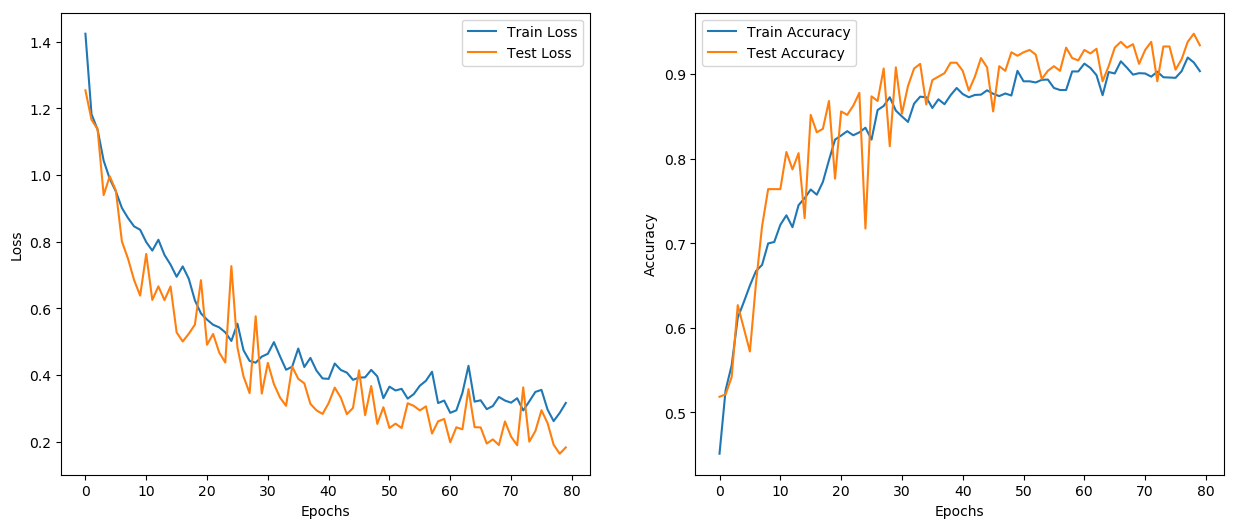

In [206]:
plt.figure(figsize=(15, 6))

plt.subplot(121)
sns.lineplot(x=range(epochs), y=train_losses, label='Train Loss')
sns.lineplot(x=range(epochs), y=test_losses, label='Test Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(122)
sns.lineplot(x=range(epochs), y=train_accs, label='Train Accuracy')
sns.lineplot(x=range(epochs), y=test_accs, label='Test Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [209]:
save_model(model, 'gnn.safetensors')